In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import mozaik
import nest

from parameters import ParameterSet
from mozaik.storage.datastore import PickledDataStore

from scipy.interpolate import NearestNDInterpolator

import os
import sys
import pickle

from pathlib import Path
data_path = Path('/home/pavel/academia/mean-field-CSNG/data')

In [6]:
data_file = 'datastore.recordings.pickle'
with open(data_path / data_file, 'rb') as pickle_file:
    recordings = pickle.load(pickle_file)
# data is a neoblock - https://neo.readthedocs.io/en/stable/core.html
### Data about neurons - data.annotations  
# keys = ['neuron_ids', 'neuron_positions', 'neuron_annotations', 
#         'model_parameters', 'sheet_parameters', 'experiment_parameters',
#         'simulation_log']
### neuron positions
# data.annotations['neuron_positions'][population][axis, neuron_idx]  
# axis = (x,y,z), z = 0
### neuron indices
# data.annotations['neuron_ids'][population]  
### neuron properties
# data.annotations['neuron_annotations'][population][neuron_idx][parameter]
# Parameters:
# 'LGNAfferentOrientation', 'LGNAfferentAspectRatio', 'LGNAfferentFrequency',
# 'LGNAfferentSize', 'LGNAfferentPhase', 'LGNAfferentX', 'LGNAfferentY'
# 'aff_samples'  
#
#  'aff_samples'  is the number of afferent connections from LGN (variable!)
### Model, sheet, experiment parameters
# Parameters are in a string had to be processed



data_file = 'datastore.analysis.pickle'
with open(data_path / data_file, 'rb') as pickle_file:
    analysis = pickle.load(pickle_file)
# this is a list 


# data_file = 'datastore.sensory.stimulus.pickle'
# with open(data_path / data_file, 'rb') as pickle_file:
#     stimulus = pickle.load(pickle_file)

data_store = PickledDataStore(load=True, parameters=ParameterSet(
    {'root_directory': str(data_path), 'store_stimuli': False}), replace=True)

In [7]:
data_store.get_neuron_annotations()['V1_Exc_L4']
# data_store.get_neuron_positions()['V1_Exc_L4']


[OrderedDict([('LGNAfferentOrientation', 0.495481177724157),
              ('LGNAfferentAspectRatio', 0.4),
              ('LGNAfferentFrequency', 0.8),
              ('LGNAfferentSize', 0.17),
              ('LGNAfferentPhase', 2.1930629396900594),
              ('aff_samples', 81.99647855697609),
              ('LGNAfferentX', -2.2721614869347464),
              ('LGNAfferentY', -0.8846403716600454)]),
 OrderedDict([('LGNAfferentOrientation', 1.4596835740096497),
              ('LGNAfferentAspectRatio', 0.4),
              ('LGNAfferentFrequency', 0.8),
              ('LGNAfferentSize', 0.17),
              ('LGNAfferentPhase', 2.3279650257637905),
              ('aff_samples', 74.60159915079093),
              ('LGNAfferentX', 1.3242987281679641),
              ('LGNAfferentY', 0.4635491844658718)]),
 OrderedDict([('LGNAfferentOrientation', 1.1843437269851957),
              ('LGNAfferentAspectRatio', 0.4),
              ('LGNAfferentFrequency', 0.8),
              ('LGNAfferentSize

# Explore orientation map 

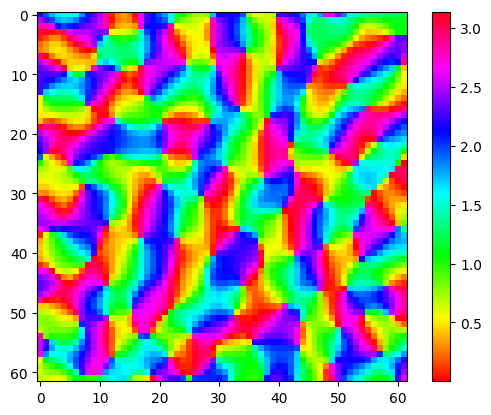

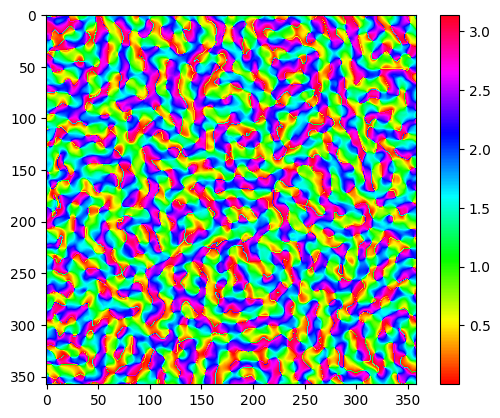

In [12]:
# Predefined maps

map_file = 'or_map_new_6x6'  # (62,62)
with open(data_path / map_file, 'rb') as f:
    mmap = pickle.load(f, encoding="latin1")
plt.imshow(mmap*np.pi, cmap='hsv')
plt.colorbar()
plt.show()

map_file2 = 'or_map_new_16x16'  # (358, 358)
with open(data_path / map_file2, 'rb') as f:
    mmap2 = pickle.load(f, encoding="latin1")
plt.imshow(mmap2*np.pi, cmap='hsv')
plt.colorbar()
plt.show()

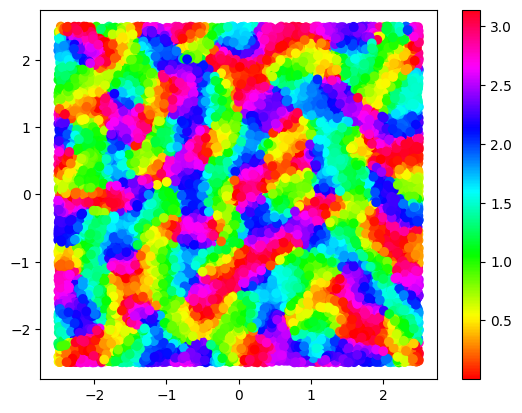

In [19]:
# Orientations of neurons

population = 'V1_Exc_L4'
xs, ys, _ = data_store.get_neuron_positions()[population]
orientations = np.array([x['LGNAfferentOrientation'] for x in data_store.get_neuron_annotations()[population]])

plt.scatter(xs, ys, c=orientations, cmap='hsv')
plt.colorbar()
plt.show()

In [22]:
# Computing orientation based on interpolation of Orientation maps

# Size of predefined map - in degrees of visual field
or_map_size = (16.75, 16.75)

# Define coordinates grid
coords_x = np.linspace(-or_map_size[0]/2.0, or_map_size[0]/2.0, mmap2.shape[0])
coords_y = np.linspace(-or_map_size[1]/2.0, or_map_size[1]/2.0, mmap2.shape[1])
Y, X = np.meshgrid(coords_y, coords_x)

# Create interpolator instance
or_map = NearestNDInterpolator(list(zip(X.flatten(), Y.flatten())), mmap2.flatten())

x_position = 0.
y_position = 0.
preferred_orientation = or_map(x_position, y_position)

array(0.00755354)

# Reducing connectivity & and orientations to 2D grid

In [23]:
connections = []
for conn in analysis:
    if type(conn) is mozaik.analysis.data_structures.Connections:
        connections.append(conn)

populations = ['X_ON', 'X_OFF', 'V1_Exc_L4', 'V1_Inh_L4']
num_inh_neurons = len(recordings.annotations['neuron_annotations']['V1_Inh_L4'])  # 9375
num_exc_neurons = len(recordings.annotations['neuron_annotations']['V1_Exc_L4'])  # 37500


grid_size = 0.250  # mm



assert 5000 % int(grid_size*1000) == 0, "Incomplete grid division is not implemented"
cols = 5000 // int(grid_size*1000)


positions = recordings.annotations['neuron_positions']
grid_positions = dict()
for population, positions in positions.items():
    # Rounding error?
    positions = (positions//grid_size).astype(int)
    positions = positions[:-1] - positions[:-1].min(axis=1)[:,np.newaxis]
    grid_positions[population] = (positions * np.array([cols, 1])[:,np.newaxis]).sum(axis=0)


mf_conns = dict()
for connection in connections:
    base_weight = connection.weights[:,2].min()
    mf_conns[connection.proj_name] = np.zeros((cols**2, cols**2), dtype=int)
    b = np.zeros_like(connection.weights, dtype=int)
    # Converts index of a neuron to index of a grid --> source grid of each connection
    b[:,0] = grid_positions[connection.source_name][connection.weights[:,0].astype(int)]
    # Converts index of a neuron to index of a grid --> target grid of each connection
    b[:,1] = grid_positions[connection.target_name][connection.weights[:,1].astype(int)]
    b[:,2] = np.round(connection.weights[:,2]/base_weight).astype(int)  # number of connections

    bins = np.arange(cols**2+1)
    for target_grid in range(cols**2):
        g = b[np.flatnonzero(b[:,1]==target_grid), 0]
        w = b[np.flatnonzero(b[:,1]==target_grid), 2]
        hist, _ = np.histogram(g, bins=bins, weights=w)
        mf_conns[connection.proj_name][:,target_grid] = hist
        
        # Alternative:
        # Slo by to bez for loop?
        # h = np.zeros(grids.max()+1,dtype=int)
        # for i in range(grids.max()+1):
        #     h[i] = w[(g==i).nonzero()].sum()
        # histogram for each grid point
   
# np.histogram2d - timhle by nebylo potreba prepocitavat grids??
    # ale nevim jak sgrupovat vetsi mnozstvi na vstupu, musel bych to delat neuron po neuronu



# TODOs: (~ a week)
# 1. Faycal Orient Maps
# 2a. 2D MF play with
# 2b. Read Master Thesis
# 3. implement connectivity
# how to use np.histogram2d
# Compute histograms 2d could be faster than for loops
# 
# TODO: allow all grid_sizes
# TODO: centering?
# TODO: make the assertion size dependent
# TODO: update to non-square sheet
# connections[0].target_size
# connections[0].source_size  # (mm, mm)


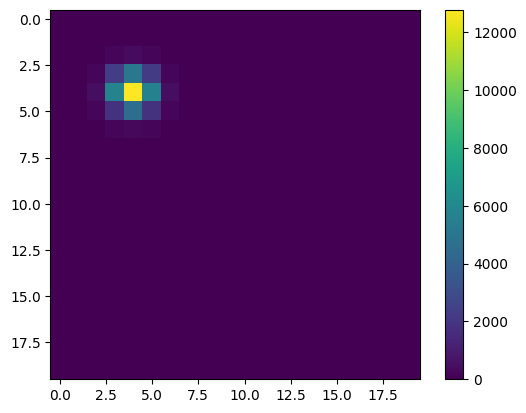

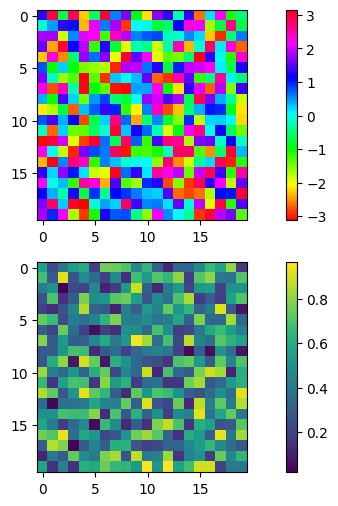

In [26]:
connectivity = 'V1L4ExcL4ExcConnection'
col = 4
row = 4
plt.imshow(mf_conns[connectivity][:,row*cols+col].reshape(cols,cols))
plt.colorbar()
# Make a GIF?


orientations = np.zeros(cols**2, dtype=complex)
orientations_weight = np.zeros(cols**2, dtype=int)

population = 'V1_Exc_L4'
for i in range(37500):
    orient = recordings.annotations['neuron_annotations'][population][i]['LGNAfferentOrientation']
    orientations[grid_positions[population][i]] += np.exp(1j*2*np.pi*orient)
    orientations_weight[grid_positions[population][i]] += 1
    # x, y = data.annotations['neuron_positions']['V1_Exc_L4'][:2,i]

orient = orientations/orientations_weight
orientations_angle = np.angle(orient)
orientations_magnitude = np.abs(orient)


plt.figure(figsize=(10, 6))

# Plot membrane potential
plt.subplot(2, 1, 1)
plt.imshow(orientations_angle.reshape(cols, cols), cmap='hsv')
plt.colorbar()

plt.subplot(2, 1, 2)
plt.imshow(orientations_magnitude.reshape(cols,cols))
plt.colorbar()

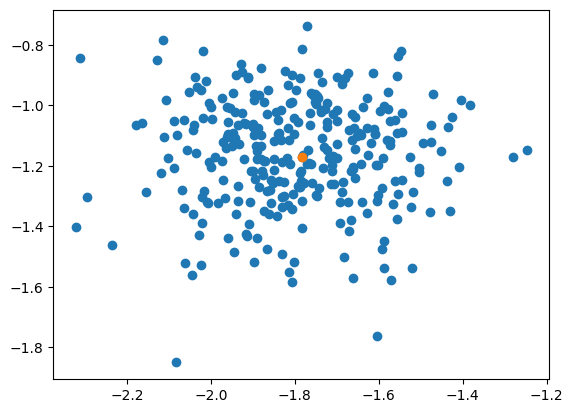

In [27]:
# How to make connection plot (incoming/outgoing connections to a given neuron)


index = 1000  # neuron index
connection_index = 0

conns = connections[connection_index]  # connections data
base_weight = conns.weights[:,2].min()  # base_weight
idx = np.array(np.flatnonzero(conns.weights[:,1].flatten() == index))  # index of connections
number_conns = np.round(conns.weights[idx,2]/base_weight).astype(int)  # number of connections between
source_neurons = conns.weights[idx,0].astype(int)  # numbers of presynaptic neurons
lgn_aff = 2*int(recordings.annotations['neuron_annotations'][conns.target_name][index]['aff_samples'])

source_positions = recordings.annotations['neuron_positions'][conns.source_name][:,source_neurons]
target_position = recordings.annotations['neuron_positions'][conns.target_name][:,index]

grid_position = recordings.annotations['neuron_positions'][conns.source_name]
exc_grid_position = (recordings.annotations['neuron_positions'][conns.source_name]//grid_size).astype(int)
inh_grid_position = (recordings.annotations['neuron_positions'][conns.source_name]//grid_size).astype(int)

# TODO: center the grid
grid_position = {
    'V1_Exc_L4' : (recordings.annotations['neuron_positions']['V1_Exc_L4']//grid_size).astype(int),
    'V1_Inh_L4' : (recordings.annotations['neuron_positions']['V1_Inh_L4']//grid_size).astype(int),
}


plt.scatter(source_positions[0,:], source_positions[1,:])
plt.scatter(target_position[0], target_position[1])